#  **Cats Vs Dogs identifier using Transfer Learning**
 ![o](c.gif)

## **Overview**
---


In this project we are going to train our deep learning model on __[*Kaggle Competition 2013 Dataset*](https://www.kaggle.com/c/dogs-vs-cats/data)__ so that it is able to identify whether a picture is of a Dog or Cat. We will be using a pretrained model on **ImageNet** and then add some custom layers for increasing accuracy

### **Data Collection**
---

Data can be easily download from the following links:


Train | Valid | Test
-     | -     | -
__[Images Train](https://drive.google.com/open?id=1r0G39tYaSe7fObGIw6vlxUhv-HkENu4W)__ | __[Images Valid](https://drive.google.com/open?id=1_eMoeMi4KjTbcZpBr1Elz8gNU5SNIyiD)__ | __[Images Test](https://drive.google.com/open?id=1yLGqMixFsqzVznWU8rWrJ9ZHjVDIDTxG)__
__[Labels Train](https://drive.google.com/open?id=1BEIuwRmS3Md1FgtdW6_45xiH-ysOWjV4)__ | __[Labels Valid](https://drive.google.com/open?id=19SS_jVTPqISO36R6Gia58MSAxAOT4-a8)__ | __[Labels Test](https://drive.google.com/open?id=1KGBMlxxA7b6m2rOIIM3DH2462ZUsP96z)__ 

![i](https://uploads-ssl.webflow.com/6098e41066be8b2b7cb437cd/60f54b1f9441c91544eccda5_data-revenue.gif)

### **Deliverables**
---

__We have to submit *API* with a Demo of working model__

![Here](https://cdn.dribbble.com/users/1663650/screenshots/7229818/media/3f830cdb4791bd82ccec36aea3f1666b.gif)

## **Implementation**

1. Setting Essential Modules & Configurations
2. Processing Given Data
    - Forming Tensors
    - Creating Datasets & DataLoaders
    - Visualizing Some of Data in Matplotlib
3. Choosing a Model
    - Using a pretrained model
    - Changing its fully connected layer according to Outputs
    - Training it on Training DataLoader
    - Validating it by Validation DataLoader
4. Changing & Setting the Architecture
    - Changing Optimizer
    - Changing the activation function and compares for the best
    - Changing batch size for the best
5. Plotting the results by the Final Model
    - Plotting Some Images test with their accuracy
    - Finding Confusion Matrix

### **1. Setting Essential Modules & Configurations**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision 
from torch.nn import functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset

Mounted at /content/drive


#### **Constant Configurations**


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

### **2. Processing Given Data**

#### **Converting Data to Tensors**

In [4]:
# Images Tensors
image_test = torch.from_numpy(np.load('/content/drive/MyDrive/data/images_test.npy'))
image_train = torch.from_numpy(np.load('/content/drive/MyDrive/data/images_train.npy'))
image_valid = torch.from_numpy(np.load('/content/drive/MyDrive/data/images_valid.npy'))
# Conversion image tenors as (Batch, size, channel) >> (Batch, channel, size)
image_train = image_train.permute(0,3,1,2)
image_valid = image_valid.permute(0,3,1,2)
image_test = image_test.permute(0,3,1,2)
# Labels Tensors
label_train = torch.from_numpy(np.load('/content/drive/MyDrive/data/labels_train.npy'))
label_test = torch.from_numpy(np.load('/content/drive/MyDrive/data/labels_test.npy'))
label_valid = torch.from_numpy(np.load('/content/drive/MyDrive/data/labels_valid.npy'))

#### **Creating Datasets using utility class**

In [5]:
train_set = TensorDataset(image_train.float(),label_train.long())
valid_set = TensorDataset(image_valid.float(),label_valid.long())
test_set = TensorDataset(image_test.float(),label_test.long())

#### **Creating DataLoaders using utility class**

In [48]:
train_loader = DataLoader(train_set, batch_size=16)
valid_loader = DataLoader(valid_set, batch_size=16)                                
test_loader = DataLoader(test_set, batch_size=16)


In [49]:
a = next(iter(train_loader))
a[0].size()

torch.Size([16, 3, 160, 160])

#### **Visualizing Some Data**

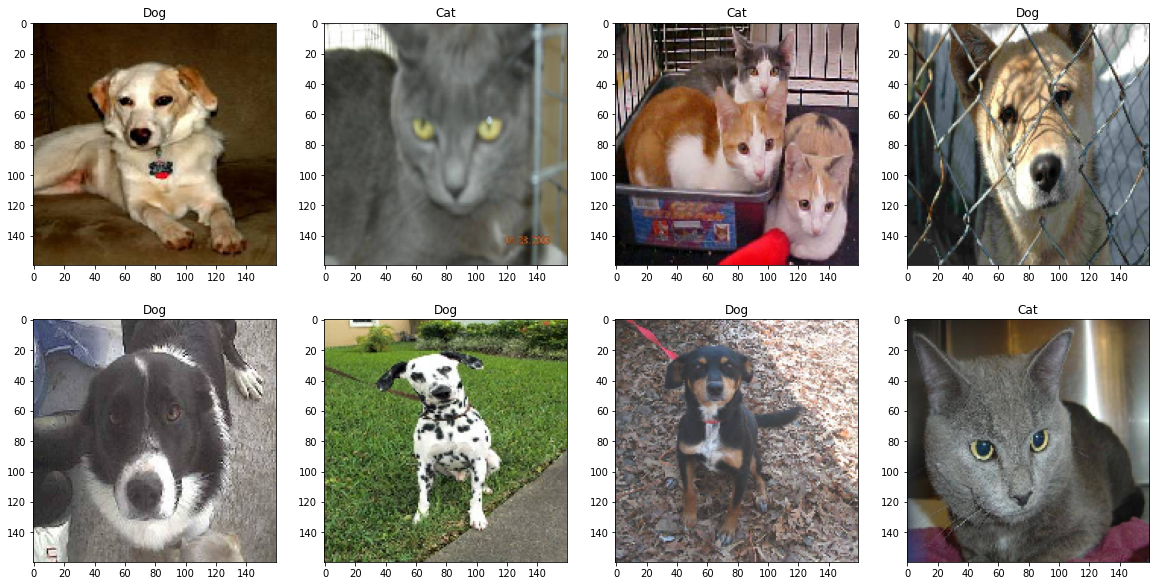

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for n in range(1,3):
  for i, img in enumerate(next(iter(train_loader))[0][4*n-4:4*n]):
      ax = axs[n-1][i]
      labels = ['Cat' if next(iter(train_loader))[1][a]==1 else 'Dog' for a in range(4*n-4,4*n)]
      ax.set_title(labels[i])
      ax.imshow(img.permute(1,2,0).int())

### **3. Choosing a Model**

In [50]:
dataloaders = {
    'train':
    train_loader,
    'validation':
    valid_loader
}

# Model 1
model = torchvision.models.resnet50(pretrained=True)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.LeakyReLU(inplace=True),
               nn.Linear(128,2)).to(device)

optimizer = optim.Adam(model.fc.parameters())
model = model.to(device)

#### **Training & Validation on DataLoaders**

In [20]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs,labels)

                if phase == 'train':

                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                _,preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
              epoch_loss = running_loss / len(train_set)
              epoch_acc = running_corrects.double() / len(train_set)
            else:
              epoch_loss = running_loss / len(valid_set)
              epoch_acc = running_corrects.double() / len(valid_set)


            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [51]:
model_trained = train_model(model,criterion,optimizer,5)

Epoch 1/5
----------
train loss: 0.2805, acc: 0.8567
validation loss: 0.1579, acc: 0.9133
Epoch 2/5
----------
train loss: 0.1208, acc: 0.9550
validation loss: 0.2026, acc: 0.9233
Epoch 3/5
----------
train loss: 0.1005, acc: 0.9633
validation loss: 0.3453, acc: 0.9067
Epoch 4/5
----------
train loss: 0.0590, acc: 0.9833
validation loss: 0.2868, acc: 0.9133
Epoch 5/5
----------
train loss: 0.0396, acc: 0.9917
validation loss: 0.3156, acc: 0.9200


### **4. Changing & Setting the Architecture**

#### **Changing Optimizer**

**optim.Adam(model.fc.parameters())** | **optim.Adam(model.parameters())**
- | -
<img src='gallery/m1.jpg'> | <img src='gallery/m2.jpg'>
<img src='gallery/ac(Leakyrelu) test.jpg'> | <img src='gallery/m2(conf).jpg'>
✔️ | ❌

#### **Changing the activation function**

**LeakyReLU** | **ReLU**
- | -
<img src='gallery/ac(Leakyrelu).jpg'> | <img src='gallery/ac(relu).jpg'>
<img src='gallery/ac(Leakyrelu) test.jpg'> | <img src='gallery/ac(relu) test.jpg'>
✔️ | ❌

#### **Changing batch size**

**Batch Size = 16** | **Batch Size = 8**
- | -
<img src='gallery/m1.jpg'> | <img src='gallery/batch 8.jpg'>
<img src='gallery/ac(Leakyrelu) test.jpg'> | <img src='gallery/batch 8 test.jpg'>
✔️ | ❌

### **Selected Model**
Hence Resnet50 with 
- Optimization of Last Fully Connected Layer
- Activation of LeakyReLU
- Batch Size of 16

is selected for best results

### **5. Plotting the results by the Final Model**

#### **Saving weights**

In [52]:
torch.save(model_trained.state_dict(), '/content/drive/MyDrive/models/weights1.h5')

#### **Final Testing**

In [53]:
model = torchvision.models.resnet50(pretrained=False).to(device)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.LeakyReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/models/weights1.h5'))

<All keys matched successfully>

#### **Drawing Confusion Matrix**

In [54]:
class_correct = [0. for _ in range(2)]
total_correct = [0. for _ in range(2)]
wrong_img,wrong_l=[],[]
output_labels=['Dogs','Cats']
with torch.no_grad():
    for images, labell in test_loader:
        images, labell = images.to(device), labell.to(device)
        outputs = model(images)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labell).squeeze()
        if labell.size()!=torch.Size([8]):
          n = 4
        else:
          n=8
        for i in range(n):
            label = labell[i]
            if c[i].item()==False:
              wrong_img.append(images[i])
              wrong_l.append(predicted[i])
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        

for i in range(2):
    print("Accuracy of {}: {:.2f}%".format(output_labels[i], class_correct[i] * 100 / total_correct[i]))
print(f'{"-"*30}\nWrong Predictions (out of 300): {len(wrong_l)}')

Accuracy of Dogs: 89.74%
Accuracy of Cats: 94.59%


#### **Plotting the wrong**

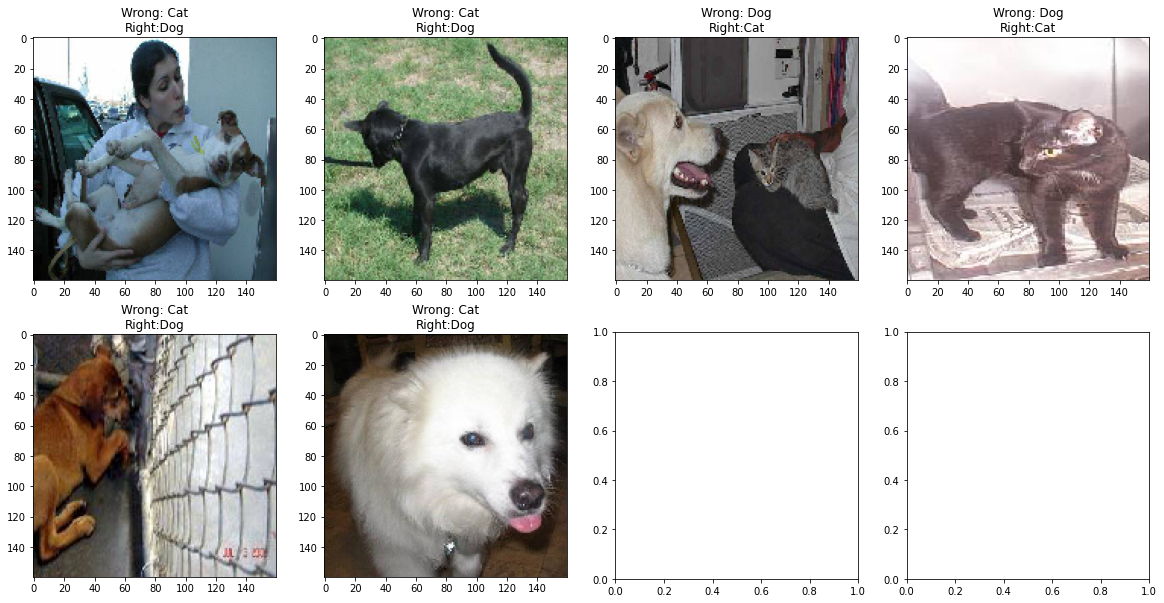

In [58]:
l = len(wrong_l)
s=0
if l%4==0:
  r=l//4
else:
  r=l//4+1
fig, axs = plt.subplots(r, 4, figsize=(20, 10))
for n in range(1,r+1):
  for i,img in enumerate(wrong_img[4*n-4:4*n]):
      ax = axs[n-1][i]
      lab = 'Cat Dog' if wrong_l[s].item() == 1 else 'Dog Cat'
      lab = lab.split(' ')
      s+=1
      ax.set_title(f'Wrong: {lab[0]}\nRight:{lab[1]}')
      ax.imshow(img.permute(1,2,0).to('cpu').int())

#### **Pickling the model**

In [59]:
torch.save(model.to('cpu'), 'model.pkl')

#### **Developing Gradio App**

In [ ]:
# !pip install gradio
import os
env_var = os.environ.get('env')
import torch
import time 
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms

device = 'cpu'
model = torch.load('model.pkl').to(device).eval()
transform = transforms.Resize(size=500)
labels = ['Cat', 'Dog']

def predict(image):
  start = time.time()
  with torch.no_grad():
    image = Image.fromarray(np.uint8(image)).convert('RGB')
    image = transform(image)
    image = np.array(image)
    image = torch.from_numpy(image).permute(2,0,1).float()
    image = image.unsqueeze(0)
    prediction = model(image.to(device))
    pred_idx = np.argmax(prediction.to(device))
    pred_label = "Cat" if pred_idx == 0 else "Dog"
    label = [l for l in labels if l!=pred_label]
    confidences = {pred_label: float(prediction[0][pred_idx])/100, label[len(label)-1]: 1-(float(prediction[0][pred_idx]))/100 }  
    infer = time.time()-start  
  return confidences,infer

gr.Interface(fn=predict,
             inputs=gr.inputs.Image(shape=(512, 512)), 
             outputs=[gr.outputs.Label(num_top_classes=3), gr.outputs.Textbox('infer',label='Inference Time')],
             examples=['1.jpg','2.jpg', '3.jpg', '4.jpg', '5.jpg']).launch()

## Try My App by clicking the button below
---

'https://huggingface.co/spaces/mda1458/Cats_vs_Dogs'

# Thank You